In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from mpl_toolkits import mplot3d
from scipy import interpolate
import matplotlib.tri as tri

In [2]:
# Functions describing the dynamics and the likelihoods corresponding to noise density

def Likelihoods(y,Cov_inv):
    helper1=sum(-1/2*Cov_inv@(y**2),0) #Only valid for diagonal covariances
    Likelihood=np.exp(helper1)
    Likelihood=Likelihood/Likelihood.sum()
    return Likelihood

def Dynamics(Grid,u): #dynamics of the whole grid (at once)
    Gridplus=np.full(Grid.shape, np.nan)
    Gridplus[0,:]=0.9*Grid[0,:]+0.2*Grid[1,:]
    Gridplus[1,:]=-0.15*Grid[0,:]+0.9*Grid[1,:]+0.05*Grid[0,:]*Grid[1,:]+u
    return Gridplus

def DynamicsScalar(x,u): # dynamics for a single state vector
    xplus=np.full(x.shape, np.nan)
    xplus[0]=0.9*x[0]+0.2*x[1]
    xplus[1]=-0.15*x[0]+0.9*x[1]+0.05*x[0]*x[1]+u
    return xplus


Text(0, 0.5, '$h_k$')

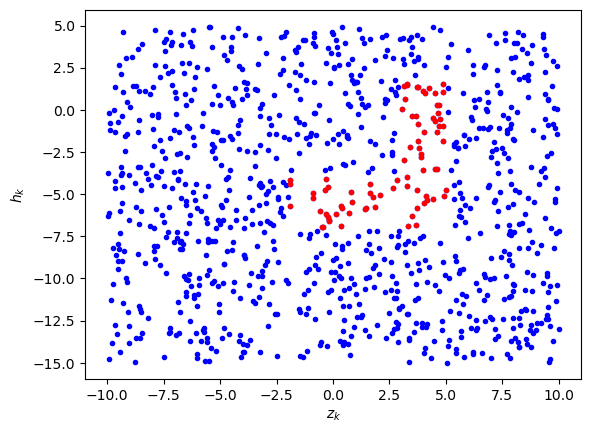

In [3]:
# Here we define the Dynamic Programming problem parameters
alpha=0.9 # the discount factor
Ulim=3 # the upper limit of |u|
Ss=1000 # state space grid size
Us=50 # input space grid size
epsilon=0.3 # acceptable violation rate, beyond that a near infinity penalty is assigned

# Gridding the state space
xlimits=10
shift=5

Grid=np.array([ [np.random.uniform(-xlimits,xlimits,Ss)],[np.random.uniform(-xlimits-shift,xlimits-shift,Ss)] ]).reshape(2,Ss)

#Points of the grid representing the constraint
Grid_ind_Constraint=(((3<Grid[0,:])&(Grid[0,:]<5))&((-4<Grid[1,:])&(Grid[1,:]<2)) | ((-2<Grid[0,:])&(Grid[0,:]<5))&((-7<Grid[1,:])&(Grid[1,:]<-4)))

var_w=np.diag(np.array([0.3,0.3]))
V=np.ones((Ss,))
U=np.random.uniform(-Ulim,Ulim,Us)
VU=np.zeros((Us,))
Vj=np.ones((Ss,))
Ugrid=np.zeros((Ss,))


#Vj[Grid_ind_Constraint]=10**6
plt.plot(Grid[0,:],Grid[1,:],'.b')
plt.plot(Grid[0,Grid_ind_Constraint],Grid[1,Grid_ind_Constraint],'.r')
plt.xlabel('$z_k$')
plt.ylabel('$h_k$')

In [4]:
# Start DP algorithm, Value Iteration, 200 steps, but it will converge much earlier
for k in range(200):
    print(Grid_ind_Constraint.sum())
    for i in range(Ss):
        #if (Grid_ind_Constraint[i]==True):
         #   continue
        anyInFeasibleU=np.full(VU.shape, False)
        x=Grid[:,i]
        for jj in range(Us):
            u=U[jj]
            xplus=DynamicsScalar(x,u)
            Likelihoods_u=Likelihoods(Grid-xplus.reshape(2,1)@np.ones((1,Ss)), np.linalg.inv(var_w))
            # Performance
            VU[jj]=u**2 + alpha*Likelihoods_u@V  
            # Feasibility
            Test=Likelihoods_u[Grid_ind_Constraint].sum() 
            if (Test>epsilon):
                anyInFeasibleU[jj]=True
        
                  
        if all(anyInFeasibleU):
            Grid_ind_Constraint[i]=True
            continue
        else:
            I=np.argmin(VU)
            Vj[i]=VU[I]+sum(x**2)
            Ugrid[i]=U[I]
        
    err=abs((Vj-V)/Vj).max()
    print('rel. error is ',round(err*100,3), '%')
    V=Vj-1+1
    if err<0.05: #stop dynamic programming if |Vplus-V|_infty < some error
        print('VI converged')
        break



80
rel. error is  99.685 %
88
rel. error is  50.662 %
88
rel. error is  33.587 %
88
rel. error is  25.126 %
88
rel. error is  19.991 %
88
rel. error is  16.172 %
88
rel. error is  13.192 %
88
rel. error is  10.853 %
88
rel. error is  9.009 %
88
rel. error is  7.548 %
88
rel. error is  6.381 %
88
rel. error is  5.44 %
88
rel. error is  4.671 %
VI converged


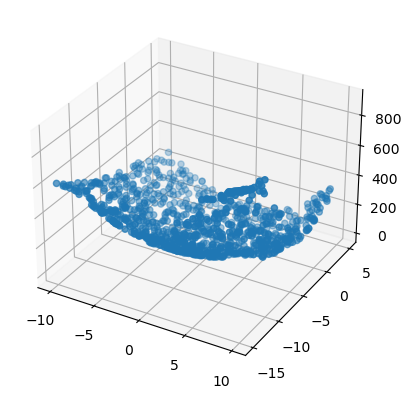

In [5]:
ax = plt.axes(projection='3d')
ax.scatter3D(Grid[0,:], Grid[1,:], V, cmap='Greens')

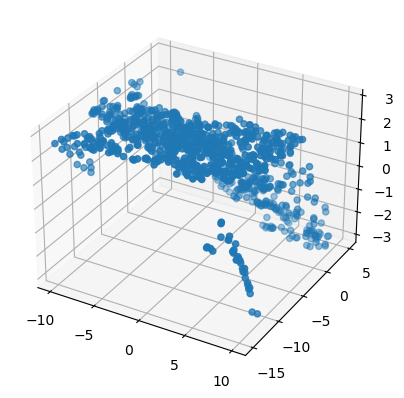

In [6]:
ax = plt.axes(projection='3d')
ax.scatter3D(Grid[0,:], Grid[1,:], Ugrid, cmap='Greens')

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


C:\Users\msram\AppData\Local\Temp\ipykernel_19004\2306934509.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


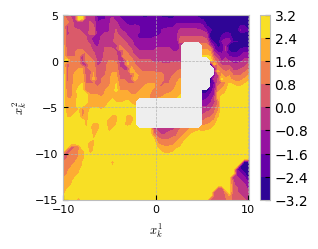

In [7]:
# Redefine the feasible controller on a simpler grid
nn=50
x=np.linspace(-xlimits,xlimits,nn)
y=x-shift
xx, yy = np.meshgrid(x,y)
uStar=np.zeros(xx.shape)
vStar=np.zeros(xx.shape)
Feasibility0=np.zeros(xx.shape)
for i in range(nn):
    print(i/nn)
    for j in range(nn):
        for jj in range(Us):
            xij=np.array([ xx[i,j], yy[i,j] ])
            if (((3<xx[i,j])&(xx[i,j]<5))&((-4<yy[i,j])&(yy[i,j]<2)) | ((-2<xx[i,j])&(xx[i,j]<5))&((-7<yy[i,j])&(yy[i,j]<-4))):
                Feasibility0[i,j]=1
                
            u=U[jj]
            xijplus=DynamicsScalar(xij,u)
            Likelihood=Likelihoods(Grid-xijplus.reshape(2,1)@np.ones((1,Ss)), np.linalg.inv(var_w))
            Test=Likelihood[Grid_ind_Constraint].sum() 
            if (Test>epsilon):
                VU[jj]=10**6
            else:
                VU[jj]=sum(xij**2)+u**2+ alpha*Likelihood@V
        
        I=np.argmin(VU)
        uStar[i,j]=U[I]
        vStar[i,j]=VU[I]
        


# Save the controller in a format in which linear interpolation can be used later.
np.save('KlookuptableX.npy', x)
np.save('KlookuptableY.npy', y)
np.save('KlookuptableU.npy',uStar)


plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.4))
#plt.rc( 'text', usetex=True )
ax = plt.axes()
plt.axis('equal')
# Creating plot

U=uStar
U[vStar==10**6]=np.nan
U[Feasibility0==1]=np.nan
plt.contourf(xx, yy, U, cmap=plt.cm.get_cmap('plasma'))
plt.colorbar()
plt.rc('xtick', labelsize=9) #fontsize of the x tick labels
plt.rc('ytick', labelsize=9) #fontsize of the y tick labels
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8) 
plt.xlim((-10,10))
plt.ylim((-15,5))
plt.savefig('controlLawColorMap.pdf',bbox_inches ="tight")
plt.show()
# show plot
plt.show()